In [191]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [192]:
# Load and preprocess the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df = df.drop(columns=['Close'])  # Drop 'Close' as it's unused
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define features and extract data
features = ['Adj Close', 'Open', 'High', 'Low', 'Volume', 'ATR', 'ADX', 'RSI', 
            'MACD', 'MACD_Signal', 'Volatility', 'Max_Drawdown']
data = df[features].values

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_sequences(data, sequence_length=30):
    """
    Create sequences of past data for LSTM.
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Sequence of 'sequence_length' days
        y.append(data[i, 0])  # Target is the 'Adj Close' column
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [193]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=100, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Last time step's output
        return out

In [194]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_size=X_train.shape[2]).to(device)
criterion = nn.SmoothL1Loss() # Huber loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Training the model
num_epochs = 35
batch_size = 32
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train_tensor[i:i+batch_size].to(device)
        targets = y_train_tensor[i:i+batch_size].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(X_train))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test_tensor[i:i+batch_size].to(device)
            targets = y_test_tensor[i:i+batch_size].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(X_test))    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss / len(X_train):.6f}, Val Loss: {val_loss / len(X_test):.6f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()

# Rescale predictions
zero_features = np.mean(data[:, 1:], axis=0)
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.tile(zero_features, (y_pred.shape[0], 1)))))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.tile(zero_features, (y_test.shape[0], 1)))))[:, 0]

# Calculate metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
accuracy = [abs((pred - actual) / actual) <= 0.01 for pred, actual in zip(y_pred_rescaled, y_test_rescaled)]
accuracy_rate = sum(accuracy) / len(accuracy) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, Accuracy (within 1% error): {accuracy_rate:.2f}%")

/Users/xingleyang/anaconda3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/35, Train Loss: 0.000189, Val Loss: 0.002556
Epoch 2/35, Train Loss: 0.000235, Val Loss: 0.002592
Epoch 3/35, Train Loss: 0.000170, Val Loss: 0.002077
Epoch 4/35, Train Loss: 0.000128, Val Loss: 0.001416
Epoch 5/35, Train Loss: 0.000085, Val Loss: 0.000642
Epoch 6/35, Train Loss: 0.000046, Val Loss: 0.000105
Epoch 7/35, Train Loss: 0.000021, Val Loss: 0.000066
Epoch 8/35, Train Loss: 0.000011, Val Loss: 0.000063
Epoch 9/35, Train Loss: 0.000008, Val Loss: 0.000052
Epoch 10/35, Train Loss: 0.000007, Val Loss: 0.000043
Epoch 11/35, Train Loss: 0.000006, Val Loss: 0.000037
Epoch 12/35, Train Loss: 0.000006, Val Loss: 0.000033
Epoch 13/35, Train Loss: 0.000005, Val Loss: 0.000030
Epoch 14/35, Train Loss: 0.000005, Val Loss: 0.000028
Epoch 15/35, Train Loss: 0.000005, Val Loss: 0.000026
Epoch 16/35, Train Loss: 0.000004, Val Loss: 0.000025
Epoch 17/35, Train Loss: 0.000004, Val Loss: 0.000023
Epoch 18/35, Train Loss: 0.000004, Val Loss: 0.000021
Epoch 19/35, Train Loss: 0.000004, Va

In [195]:
# Print metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Model Accuracy (within 1% error): {float(accuracy_rate):.2f}%")

Mean Absolute Error: 65.25
Root Mean Square Error: 88.94
R-squared Score: 0.9818
Model Accuracy (within 1% error): 38.80%


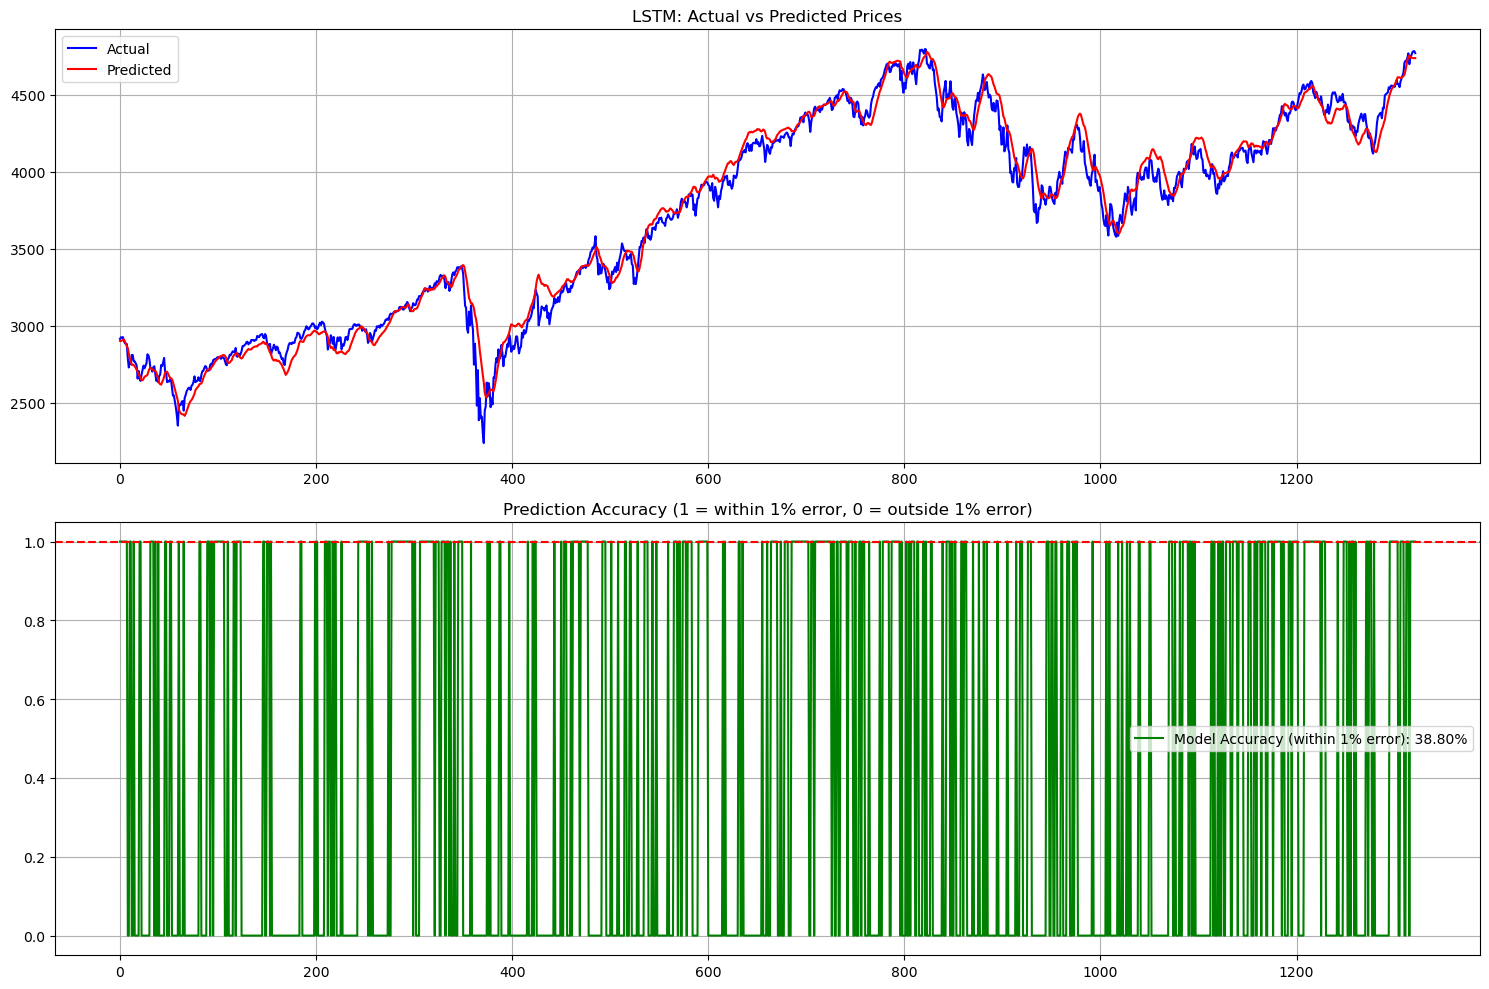

In [196]:
# Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Actual vs Predicted Prices
plt.subplot(2, 1, 1)
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue')
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted', color='red')
plt.title('LSTM: Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

# Subplot 2: Prediction Accuracy (within 1% error)
plt.subplot(2, 1, 2)
plt.plot(accuracy, label=f'Model Accuracy (within 1% error): {float(accuracy_rate):.2f}%', color='green')
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Prediction Accuracy (1 = within 1% error, 0 = outside 1% error)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
